In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from IPython.display import display
from tqdm import tqdm
import pandas as pd
import string
import torch
import json
import re

/bigwork/nhwpnagm/.conda/envs/env3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load model and data**

In [2]:
models_dir = '/bigwork/nhwpnagm/hf_models/'
model_id = 'Mistral-7B-Instruct-v0.3'
# model_id = 'Mixtral-8x7B-Instruct-v0.1'

model = AutoModelForCausalLM.from_pretrained(f'{models_dir}/{model_id}', device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(f'{models_dir}/{model_id}')

Loading checkpoint shards: 100%|██████████| 3/3 [17:04<00:00, 341.62s/it]


In [3]:
device = model.device

In [4]:
with open('../data_analysis/popquorn/extracted_texts/texts_moderate_agreement.json') as f:
    texts = json.load(f)

**Instruction sets**

In [6]:
instructions_v0 = {
    'politeness': "A text may be assigned a politeness score from 1 to 5. For each of the five politeness scores, 5 being most polite, provide an explanation for why it may apply to the following email from a colleague. Email: ",
    'offensiveness': "A text may be assigned an offensiveness score from 1 to 5. For each of the five offensiveness scores, 5 being most offensive, provide an explanation for why it may apply to the following Reddit comment. Comment: ",
    'qa': "A question may be assigned a difficulty score from 1 to 5. For each of the five difficulty scores, 5 being most difficult, provide an explanation for why it may apply to the following text passage and associated question. Passage: "
}

instructions_v1 = {
    'politeness': "You will be given an email from a colleague. The politeness of the email may be scored from 1 to 5, 5 being most polite. For each of the five politeness scores provide an explanation for why it may apply. Email: ",
    'offensiveness': "You will be given a Reddit comment. The offensiveness of the comment may be scored from 1 to 5, 5 being most offensive. For each of the five offensiveness scores provide an explanation for why it may apply. Comment: ",
    'qa': "You will be given a text passage and an associated question. The difficulty of the question may be scored from 1 to 5, 5 being most difficult. For each of the five difficulty scores provide a brief explanation for why it may apply. Passage: "
}

instructions_v2 = {
    'politeness': "You will be given an email from a colleague. Your task is to generate five explanations, each one describing why that email may be assigned a politeness rating of 1, 2, 3, 4, or 5 respectively, 5 being most polite. {addition} {sociodem} Email: ",
    'offensiveness': "You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive. {addition} {sociodem} Comment: ",
    'qa': "You will be given a text passage and an associated question. Your task is to generate five explanations, each one describing why that question may be assigned a difficulty rating of 1, 2, 3, 4, or 5 respectively, 5 being most difficult. {addition} {sociodem} Passage: "
}

additions = {
    'ambiguity': "The explanations should focus on clearing up ambiguities.",
    'ambiguity_long': "The explanations should aim to disambiguate any vague or confusing content that might complicate the rating of the {task} to a human.",
    'ambiguity_long_v2': "The explanations should aim to disambiguate any vague content that might complicate the rating of the {task}.",
    'difficulty': "The explanations should focus on simplifying the contents so as to make the rating of the {task} easier to a human.",
    'difficulty_long': "The explanations should focus on simplifying the contents so as to make the rating of the {task} easier to a human.",
}

sociodemographics = {
    'fwmc': "Consider a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree' as the recipient of the explanations.",
    'fwmc_2': "Explain it to a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree'."
}

# linguistics, domain knowl., cultural 

**Function definitions**

In [62]:
profile = 'fwmc'

In [63]:
path_to_file = f'explanations/{model_id}/moderate_agreement_{profile}.json'
path_to_file # where to store the explanations

'explanations/Mistral-7B-Instruct-v0.3/moderate_agreement_fwmc.json'

In [64]:
def inference(prompt:str):
    message = [{'role': 'user', 'content': prompt}]
    inputs = tokenizer.apply_chat_template(message, tokenize=True, add_generation_prompt=True, return_tensors='pt').to(device)#.to(device=torch.device('cuda'))
    outputs = model.generate(inputs, max_new_tokens=1000)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_output.replace(prompt, "").strip()


def clean(text:str):
    text_no_html = re.sub(r'<[^>]+>', '', text)
    return re.sub(r'\s+', ' ', text_no_html).strip()


def run(instructions:dict = None, 
        instr_id:str = None, 
        addition:str = None,
        sociodem:str = None,
        tasks:list = ['offensiveness','qa','politeness']):
    
    outputs = {}
    for task in tasks:
        outputs[task] = {}
        for inst_id, text in texts[task].items():
            instr_key = instr_id if not addition else f'{instr_id}_{addition}'
            outputs[task][inst_id] = {}
            outputs[task][inst_id][instr_key] = {}
            # clean the text (mainly for QA)
            text_cleaned = clean(text)
            # construct the prompt and call the model 
            add = additions[addition] if addition else ''
            sd = sociodemographics[sociodem] if sociodem else ''
            task_desc = task if task != 'qa' else 'difficulty'
            add = add.format_map({'task':task_desc})
            prompt = instructions[task].format_map({'addition':add, 'sociodem':sd}) + text_cleaned
            print(prompt)
            output = inference(prompt)
            # save the used prompt and the model output
            outputs[task][inst_id][instr_key]['prompt'] = prompt
            outputs[task][inst_id][instr_key]['output'] = output
    return outputs


def merge_dicts(d1:dict, d2:dict):
    merged = d1.copy()
    for k, v in d2.items():
        if k in merged:
            if isinstance(merged[k], dict) and isinstance(v, dict):
                merged[k] = merge_dicts(merged[k], v)
            else:
                merged[k] = v
        else:
            merged[k] = v
    return merged


def load(name:str):
    with open(name, 'r') as f:
        file = json.load(f) 
    return file


def save(outputs:dict, merge:bool = True):
    if merge:
        file = load(path_to_file)
        outputs = merge_dicts(outputs, file)
    
    with open(path_to_file, 'w') as f:
        json.dump(outputs, f) 
        
        
def inspect_expl(task:str, inst_id:str, instr_id:str):
    outputs = load(path_to_file)
    
    for instr_key in outputs[task][inst_id]:
        if instr_id in instr_key:
            print(outputs[task][inst_id][instr_key]['prompt'])
            explanations = outputs[task][inst_id][instr_key]['output'].split('\n\n')
            explanations = [e.split(':', 1)[1].strip() for e in explanations]
            
            with pd.option_context('display.max_colwidth', None): 
                display(pd.DataFrame(list(zip([1,2,3,4,5], explanations)), columns =[task, instr_key]))

**Model inference**

In [29]:
outputs = run(instructions=instructions_v2, instr_id='v2_fwmc_2', addition=None, sociodem='fwmc_2', tasks=['offensiveness'])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive.  Explain it to a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree'. Comment: Could this be because... prisons are full of actual rapists?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive.  Explain it to a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree'. Comment: Yeah, Poppy is a war criminal who will never be punished. Doesn't mean all war criminals should escape punishment. That wouldn't make sense.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive.  Explain it to a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree'. Comment: I love people using our religion to push their political agenda. If you want us to stay out of your business you better stay the hell away from ours.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive.  Explain it to a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree'. Comment: So you do believe socialization plays a huge role in people's choices, and you do acknowledge that in the past women weren't socialized to be as career focused as men, so it seems to me like you'd understand how the explanations of why the wage gap exists are not justifications and that it stems from outdated gender roles conditioning that should be eradicated.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive.  Explain it to a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree'. Comment: And the anthem protesters aren't breaking any laws. They are hurting certain peoples feelings. That's it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive.  Explain it to a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree'. Comment: I mean... you took credit for the economic goals he achieved which you yourself said were impossible to achieve. So why not...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive.  Explain it to a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree'. Comment: Obviously, the best way to show how right you are is to prove it by lying instead of having having facts to show.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive.  Explain it to a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree'. Comment: Fine with me. Done it. But I am one that can completely separate sex and intimacy. One ex who was a dom wanted to get a sex sub for us. A live-in one, eventually. We didn't get quite that far though.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive.  Explain it to a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree'. Comment: Well uhhhh... yeah. Hell, even Republicans I've talked to that are totally in on Trump are at least *okay* with it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive.  Explain it to a person of gender 'Female', race 'White', age 'Middle adulthood' and education level 'College Degree'. Comment: Doesnt sound good to me, if you are happy then why ask others if it is ok?


In [30]:
save(outputs, merge=True)

**Inspect the generated explanations**

In [48]:
inspect_expl(task='offensiveness', inst_id='367', instr_id='v2')

You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive. The explanations should focus on simplifying the contents. Comment: We care more about keeping kids off welfare. Fuck the parents.


,offensiveness,v2_difficulty
0,1,The comment expresses a strong opinion about prioritizing resources for children over parents on welfare. It does not contain any overtly offensive language or slurs.
1,2,"The comment shows a lack of empathy towards parents on welfare and prioritizes the needs of children instead. The use of the word ""fuck"" may be seen as impolite or disrespectful, but it does not contain any hate speech or slurs."
2,3,"The comment expresses a harsh attitude towards parents on welfare and prioritizes the needs of children over them. The use of the word ""fuck"" may be seen as a derogatory term towards the parents, implying a lack of concern for their situation."
3,4,"The comment expresses a callous attitude towards parents on welfare and prioritizes the needs of children over them. The use of the word ""fuck"" may be seen as a vulgar and offensive term, implying a lack of respect and compassion towards the parents."
4,5,"The comment expresses a deeply offensive attitude towards parents on welfare, using the word ""fuck"" as a derogatory term to dismiss their struggles. The comment prioritizes the needs of children over the parents, implying that they are not deserving of support or compassion. This attitude can be seen as hateful and disrespectful towards the parents and their situation."


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive. The explanations should focus on clearing up ambiguities. Comment: We care more about keeping kids off welfare. Fuck the parents.


,offensiveness,v2_ambiguity
0,1,"The comment may be rated as mildly offensive due to the use of strong language, ""Fuck the parents,"" but the overall context seems to be focused on a policy perspective, expressing concern for keeping kids off welfare. It could be interpreted as frustration with the system and not directly targeting parents as individuals."
1,2,"The comment may be rated as moderately offensive due to the use of strong language and a dismissive attitude towards parents. However, it's important to note that the comment does not contain any derogatory or hateful language towards parents based on their race, gender, or other personal characteristics."
2,3,"The comment may be rated as somewhat offensive due to the use of strong language and a dismissive attitude towards parents. The statement ""Fuck the parents"" could be interpreted as a lack of empathy or understanding for the challenges parents face, which could be perceived as insensitive."
3,4,"The comment may be rated as more offensive due to the use of strong language and a dismissive attitude towards parents. The statement ""Fuck the parents"" could be perceived as blaming parents for their children being on welfare, ignoring the complex societal and economic factors that contribute to poverty and the need for welfare."
4,5,"The comment may be rated as highly offensive due to the use of strong language and a dismissive attitude towards parents. The statement ""Fuck the parents"" could be perceived as blaming parents for their children being on welfare, ignoring the complex societal and economic factors that contribute to poverty and the need for welfare. Additionally, the use of the word ""fuck"" could be seen as a deliberate attempt to dehumanize and degrade parents, making the comment more hateful and harmful."


You will be given a Reddit comment. Your task is to generate five explanations, each one describing why that comment may be assigned an offensiveness rating of 1, 2, 3, 4, or 5 respectively, 5 being most offensive. Comment: We care more about keeping kids off welfare. Fuck the parents.


,offensiveness,v2
0,1,"This comment expresses a strong opinion about prioritizing resources for children over parents who rely on welfare. While it may come across as blunt or insensitive, it does not contain any overtly offensive language or slurs."
1,2,"The comment's tone is dismissive and demeaning towards parents on welfare, which could be perceived as offensive by some. However, it does not directly target or attack individuals, and the language used is not particularly harsh."
2,3,"The comment's focus on ""fucking the parents"" could be seen as offensive and disrespectful, especially towards those who are struggling and in need of assistance. The use of the word ""fuck"" adds a level of hostility and contempt."
3,4,"The comment's language and tone are more aggressive and derogatory, with the use of the word ""fuck"" and the dismissive attitude towards parents on welfare. This could be perceived as offensive and hurtful to those who are affected by the comment."
4,5,"The comment's use of the word ""fuck"" and its derogatory attitude towards parents on welfare could be seen as highly offensive and disrespectful. The comment does not offer any constructive solutions or empathy towards those in need, and its language is intended to belittle and demean."


___
### **APE**
**A**utomatic **P**rompt **E**ngineer

Zhou et al., 2023, "Large Language Models Are Human-Level Prompt Engineers"

[Paper](https://arxiv.org/pdf/2211.01910), [Source](https://github.com/keirp/automatic_prompt_engineer)
___

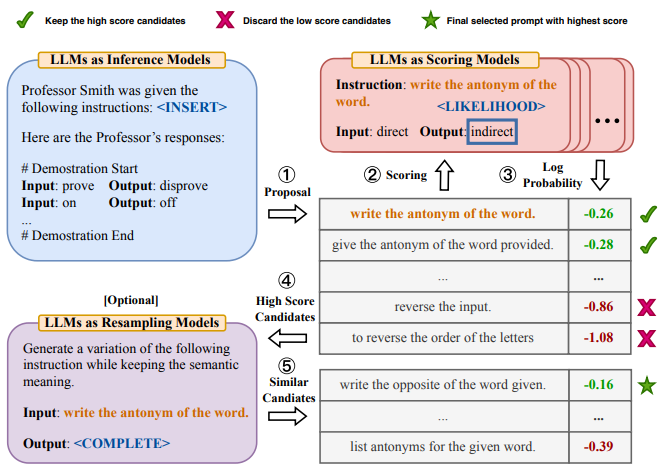

"[...] Plain language prompts do not always produce the desired results,
even when those results are possible to produce with alternative instructions. Thus, human users must
experiment with a wide range of prompts to elicit desired behaviors, as they have little knowledge of
how compatible instructions are with a particular model."

APE algorithm:
1. Use an LLM as an inference model to generate instruction candidates based on a small set of demonstrations in the form of input-output pairs
2. Guide the search process by computing a score for each instruction under the LLM we seek to control
3. LLMs improve the best candidates by proposing semantically similar instruction variants (iterative Monte Carlo search method)

"Intuitively, [the] algorithm asks LLMs to generate a set of instruction candidates
based on demonstrations and then asks them to assess which instructions are more promising."

**Provide demonstrations**

*Choose instances by hand*

In [69]:
task = 'offensiveness'
texts_sample = texts[task]

In [33]:
with open(f'explanations/{model_id}/moderate_agreement.json') as f:
    explanations = json.load(f)

In [68]:
instr_id = 'v2'
demonstrations = {}
entries = ['303', '343', '555']

for entry in entries:
    demonstrations[entry] = {
        'input': texts_sample[entry],
        'output': explanations[task][entry][instr_id]['output']
    }

**Insert demonstrations into prompts**

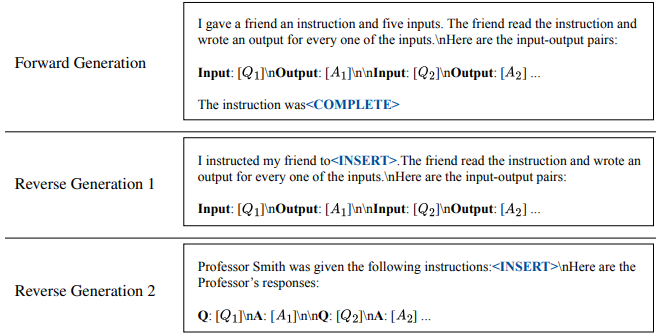

In [104]:
ape_prompts = {
    "forward_generation": 
        "I gave a friend an instruction and two inputs. The friend read the instruction and wrote an output for every one of the inputs.\nHere are the input-output pairs: Input: {input}\nOutput: {output}\n\nInput: {input2}\nOutput: {output2} The instruction was<COMPLETE>",
    "reverse_generation_1":
        "I instructed my friend to<INSERT>. The friend read the instruction and wrote an output for every one of the inputs.\nHere are the input-output pairs:Input: {input}\nOutput: {output}\n\nInput: {input2}\nOutput: {output2}",
    "reverse_generation_2":
        "Professor Smith was given the following instructions:<INSERT>\nHere are the Professor’s responses: Q: {input}\nA: {output}\n\nQ: {input2}\nA: {output2}",
    "resample_instruction": 
        "Generate a variation of the following instruction while keeping the semantic meaning. Input: {instr}\nOutput:<COMPLETE>"
}

ape_prompt = ape_prompts["forward_generation"].format_map(
    {'input':demonstrations[entries[0]]['input'], 
     'output':demonstrations[entries[0]]['output'],
     'input2':demonstrations[entries[1]]['input'], 
     'output2':demonstrations[entries[1]]['output'],
    }
)
#ape_prompt

In [105]:
output = inference(ape_prompt) # forward_generation
output

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'The instruction given was to rate the offensiveness of various comments on a scale of 1 to 5, with 1 being the least offensive and 5 being the most offensive. The comments were related to the topics of anthem protests and prisons.\n\nThe ratings were based on factors such as the use of derogatory language, minimization of important issues, othering or exclusionary language, trivialization of sensitive topics, and victim-blaming.\n\nThe ratings provided for the anthem protest comments ranged from 1 to 5, with higher ratings indicating more offensive comments. The ratings for the prison comments also ranged from 1 to 5, with higher ratings indicating more offensive comments.\n\nOverall, the ratings provided were thoughtful and well-reasoned, taking into account the context and implications of each comment. The ratings provided a useful tool for evaluating the offensiveness of various comments and for promoting respectful and inclusive dialogue.'

In [96]:
output = inference(ape_prompt) # reverse_generation_1
output

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


"These input-output pairs provide a useful framework for analyzing the offensiveness of different statements. The ratings range from 1 (least offensive) to 5 (most offensive), and each rating is accompanied by an explanation of why the statement might be considered offensive in that way.\n\nThe first set of examples focuses on the anthem protests, and the potential offensiveness of statements that imply that the feelings of some people are more important than the right to protest, dismiss the emotional impact of systemic racism and social injustice, or reinforce harmful stereotypes and contribute to a divisive narrative.\n\nThe second set of examples focuses on the topic of prisons and rape, and the potential offensiveness of statements that oversimplify the complex issues surrounding both, trivialize the seriousness of rape and the trauma it causes, blame the victims, stigmatize a large group of people, and reinforce harmful stereotypes and contribute to the stigmatization and discrim

**Testing**

In [112]:
for method in list(ape_prompts.keys())[:3]: 
    dummy_prompt = ape_prompts[method].format_map({
        'input': "prove", 
        'output': "disprove",
        'input2': "on", 
        'output2': "off",
    })
    dummy_output = inference(dummy_prompt) 
    print(dummy_prompt)
    print(dummy_output)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


I gave a friend an instruction and two inputs. The friend read the instruction and wrote an output for every one of the inputs.
Here are the input-output pairs: Input: prove
Output: disprove

Input: on
Output: off The instruction was<COMPLETE>
The instruction could have been something like: "For each given input, output the opposite." This instruction would lead to the given output pairs. For example, if the input is "on", the output would be "off" because they are opposites. Similarly, if the input is "prove", the output would be "disprove" because they are also opposites in the context of logic.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


I instructed my friend to<INSERT>. The friend read the instruction and wrote an output for every one of the inputs.
Here are the input-output pairs:Input: prove
Output: disprove

Input: on
Output: off
It seems like there might be a misunderstanding or a joke in the input-output pairs you've provided. Typically, the "prove" command is used to request evidence or justification for a statement, and the response "disprove" doesn't make sense in this context. Similarly, the "on" command is used to turn something on, and the response "off" doesn't align with that.

If this is a riddle or a joke, I'd be happy to help you understand it better! If not, I'd suggest clarifying the instructions or the responses to make them more consistent.
Professor Smith was given the following instructions:<INSERT>
Here are the Professor’s responses: Q: prove
A: disprove

Q: on
A: off
It seems there might be a misunderstanding or a mistake in the provided responses. Typically, the responses should be as follows

**Resample the instructions**

In [103]:
resample_prompt = ape_prompts["resample_instruction"].format_map({'instr': output})

resample_output = inference(resample_prompt) 
resample_output

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


"The subsequent examples serve as a valuable guide for evaluating the potential insensitivity of various statements. The ratings span from 1 (least insensitive) to 5 (most insensitive), with each rating accompanied by an explanation of why the statement may be perceived as insensitive due to its disregard for certain feelings, minimization of serious issues, victim-blaming, stigmatization of a group, or reinforcement of harmful stereotypes, thereby fostering a divisive discourse.\n\nThe initial group of examples revolves around the issue of anthem protests, and the potential insensitivity of statements that prioritize some people's feelings over the right to protest, disregard the emotional impact of systemic racism and social injustice, or perpetuate harmful stereotypes and exacerbate a divisive narrative.\n\nThe second group of examples centers on the topic of prisons and sexual assault, and the potential insensitivity of statements that oversimplify the intricate issues surrounding 